# Project 3 - Web APIs & NLP by Chenhao Andy Xu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import make_column_transformer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt

## 1. Data Cleaning and EDA

In [3]:
# import data
piano = pd.read_csv('data/piano.csv')
drum = pd.read_csv('data/drum.csv')

In [4]:
# Combine datasets
instrument = pd.concat([piano, drum])

In [5]:
# remove unnecessary columns
instrument = instrument.drop(columns = ['created_utc', 'Unnamed: 0'])
instrument.head()

,subreddit,title,selftext
0,piano,This is an original song made my me! I really ...,NaN
1,piano,Pianist Tom Brier sight-reading the notes to t...,NaN
2,piano,Country | Support Ukraine!,&amp;#x200B;\n\n*Processing video x1asqw06miw8...
3,piano,How to not get bored when I know the notes?,"Hi, I find i practise a song a lot, get it dow..."
4,piano,Scriabin op. 8 no.4,*Processing video kedok3rgjiw81...*


In [6]:
# Reset index 
instrument = instrument.reset_index()
instrument = instrument.drop(columns = ['index'])
instrument.head()

,subreddit,title,selftext
0,piano,This is an original song made my me! I really ...,NaN
1,piano,Pianist Tom Brier sight-reading the notes to t...,NaN
2,piano,Country | Support Ukraine!,&amp;#x200B;\n\n*Processing video x1asqw06miw8...
3,piano,How to not get bored when I know the notes?,"Hi, I find i practise a song a lot, get it dow..."
4,piano,Scriabin op. 8 no.4,*Processing video kedok3rgjiw81...*


In [7]:
# Convert y_value into numeric for ease of analysis later on

def y_convert(word):
    if word == 'piano':
        return 1
    elif word == 'DRUM':
        return 0

instrument['subreddit'] = instrument['subreddit'].apply(y_convert)

instrument.head()

,subreddit,title,selftext
0,1,This is an original song made my me! I really ...,NaN
1,1,Pianist Tom Brier sight-reading the notes to t...,NaN
2,1,Country | Support Ukraine!,&amp;#x200B;\n\n*Processing video x1asqw06miw8...
3,1,How to not get bored when I know the notes?,"Hi, I find i practise a song a lot, get it dow..."
4,1,Scriabin op. 8 no.4,*Processing video kedok3rgjiw81...*


In [8]:
# Check null value
instrument.isnull().sum()

subreddit       0
title           0
selftext     5606
dtype: int64

There are a lot of missing values in selftext, it's not appropriate to drop them since 5600 missing values means majority of the selftext are empty. If dropped, large amount of titles would be dropped at the same time.  
Instead, let's replace them with empty strings so that all titles can be saved. 

In [9]:
instrument = instrument.fillna('')
instrument.head()

,subreddit,title,selftext
0,1,This is an original song made my me! I really ...,
1,1,Pianist Tom Brier sight-reading the notes to t...,
2,1,Country | Support Ukraine!,&amp;#x200B;\n\n*Processing video x1asqw06miw8...
3,1,How to not get bored when I know the notes?,"Hi, I find i practise a song a lot, get it dow..."
4,1,Scriabin op. 8 no.4,*Processing video kedok3rgjiw81...*


In [10]:
instrument.shape

(7926, 3)

## 2. Simple Model with Only One Feature

In order to set the initial model, only 'title' are considered first since there's no missing values. 

In [11]:
X = instrument['title']
y = instrument['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

### 2.1. Initial Model

The purpose of initial model is to understand how the rough model performed on the dataset. At the same time, initial model helps us to understand the X and y and model performance. 

In [12]:
# Only constrain added was stop word of 'english'. This is the initial model, not many constrains added. 
pipe = make_pipeline(CountVectorizer(stop_words = 'english'), LogisticRegression(max_iter = 10000))

In [13]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [14]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9833445491251682, 0.9238143289606459)

In [15]:
cross_val_score(pipe, X_train, y_train).mean()

0.908141266888113

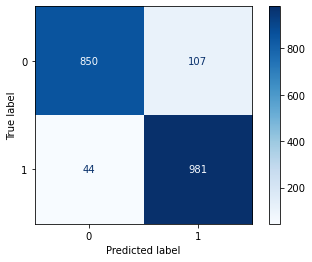

In [16]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap = 'Blues');

In [17]:
accuracy_score(y_test, pipe.predict(X_test))

0.9238143289606459

The accuracy score is quite good. In order to find out why, common words are checked to explore the cause.

In [18]:
cv = CountVectorizer(stop_words = 'english')

In [19]:
X_train_cv = cv.fit_transform(X_train)

In [20]:
df_text = pd.DataFrame(X_train_cv.A, columns = cv.get_feature_names_out())

In [21]:
df_text.sum().sort_values(ascending = False)

drum      1418
piano      986
cover      908
music      319
play       310
          ... 
hone         1
holmes       1
hollow       1
holder       1
𝐓𝐡𝐞          1
Length: 8306, dtype: int64

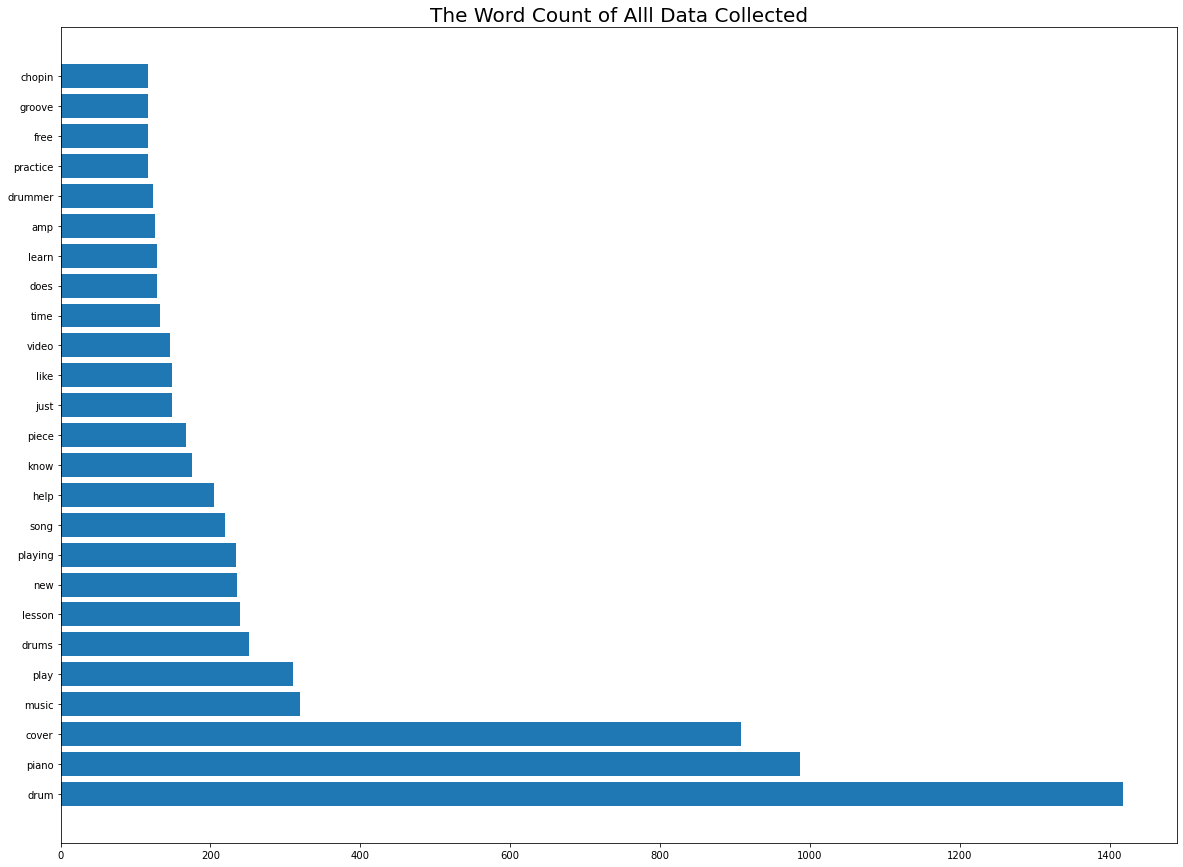

In [71]:
df_text.sum().sort_values(ascending = False).head(20)

common_word = pd.DataFrame(df_text.sum().sort_values(ascending = False).head(25), columns = ['Word Count'])
common_word = common_word.reset_index()
common_word.rename(columns = {'index': 'Word'}, inplace = True)
common_word['Word']
plt.figure(figsize = (20, 15))
plt.barh(common_word['Word'], common_word['Word Count'])
plt.title('The Word Count of Alll Data Collected', fontsize=20);
plt.savefig('images/Word_Count.jpg');

* Notice: the key words of 'piano' and 'drum' were the top words, which may significantly increase the accuracy rate. 
* The subreddits of piano and drum are selected for training the model. The model will apply to other subreddit in future. In order to increase the model compatibility，key words/most common words of 'piano' and 'drum' are added to stop words. And all the rest models would consider 'piano' and 'drum' as stop words. 
* The test size during X and y split was 0.33. 

### 2.2. Logistic Regression

In [422]:
X = instrument['title']
y = instrument['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y, test_size = 0.33)

In [72]:
# check the shape of train and test set. 
X_train.shape, X_test.shape

((5944,), (1982,))

In [73]:
# Baseline accuracy
base = y.value_counts(normalize = True)
base

1    0.517159
0    0.482841
Name: subreddit, dtype: float64

In [74]:
# add stop words
stop_words = stopwords.words('english')

add_stop_words = ['drum', 'piano']

for word in add_stop_words: 
    stop_words.append(word)

#### Lemmatizer test

In order to decide if Lemmatizer is needed in the model, it's been tested here to compare with the model without Lemmatizer because Lemmatizer is not always improve the model accuracy. 

In [393]:
import nltk
nltk.download('wordnet') 
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/AndyXu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/AndyXu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/AndyXu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [394]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    return[  wnl.lemmatize(w) for w in word_tokenize(doc)  ]

In [395]:
pipe1 = make_pipeline(CountVectorizer(stop_words = stop_words, tokenizer = lemma_tokenizer, min_df = 2), 
                      LogisticRegression(max_iter = 10000))

In [398]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function lemma_tokenizer at 0x148db9ee0>)),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [399]:
pipe1.score(X_train, y_train), pipe1.score(X_test, y_test)

(0.9391713747645951, 0.8654434250764526)

In [400]:
cross_val_score(pipe1, X_train, y_train).mean(), cross_val_score(pipe1, X_test, y_test).mean()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', '

(0.8531073446327684, 0.842887481207946)

Lemmatizer does not improve the accuracy score. 
Not just LogisticRegression - CountVectorizer model, Lemmatizer is also tried in other model. The results don't show improvement. 
So, Lemmatizer is dropped. 

#### 2.2.1. CountVectorizer + LogisticRegression

In [402]:
pipe1 = make_pipeline(CountVectorizer(stop_words = stop_words, min_df = 2), LogisticRegression(max_iter = 10000))
pipe1.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [403]:
pipe1.score(X_train, y_train), pipe1.score(X_test, y_test)

(0.9463276836158192, 0.8772935779816514)

In [429]:
log_cv_train = cross_val_score(pipe1, X_train, y_train).mean()
log_cv_test = cross_val_score(pipe1, X_test, y_test).mean()
log_cv_train, log_cv_test

(0.8668549905838041, 0.8528235517347074)

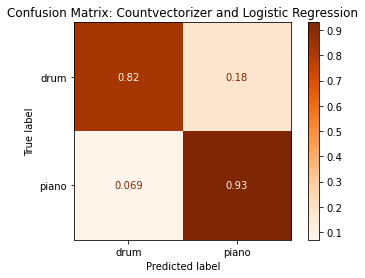

In [462]:
log_cv_conf = ConfusionMatrixDisplay.from_estimator(pipe1, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Oranges', normalize = 'true')
log_cv_conf
plt.title('Confusion Matrix: Countvectorizer and Logistic Regression');

In [463]:
log_cv_conf.figure_.savefig('./images/log_cv_conf.jpg',dpi = 100)

In [165]:
accuracy_score(y_test, pipe1.predict(X_test))

0.8772935779816514

Based on the confusion matrix, FP is what we want to reduce.

#### 2.2.2. TfidfVectorizer + LogisticRegression

Similar situation happened to TfidfVectorizer, the lemma tokenizer does not imporve the model accuracy. 

In [446]:
pipe2 = make_pipeline(TfidfVectorizer(stop_words = stop_words, min_df = 2), LogisticRegression(max_iter = 10000))

In [447]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('logisticregression', LogisticRegression(max_iter=10000))])

In [448]:
pipe2.score(X_train, y_train), pipe2.score(X_test, y_test)

(0.9310734463276836, 0.8814984709480123)

In [449]:
log_tf_train = cross_val_score(pipe2, X_train, y_train).mean()
log_tf_test = cross_val_score(pipe2, X_test, y_test).mean()
log_cv_train, log_cv_test

(0.8668549905838041, 0.8528235517347074)

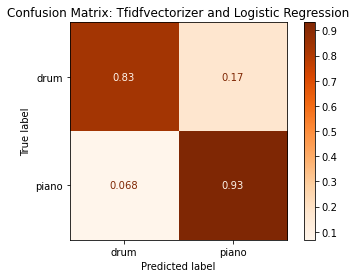

In [464]:
log_tf_conf = ConfusionMatrixDisplay.from_estimator(pipe2, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Oranges', normalize = 'true')
log_tf_conf
plt.title('Confusion Matrix: Tfidfvectorizer and Logistic Regression');

In [465]:
log_tf_conf.figure_.savefig('./images/log_tf_conf.jpg',dpi = 100)

In [173]:
accuracy_score(y_test, pipe2.predict(X_test))

0.8814984709480123

#### 2.2.3. Grid Search: CountVectorizer + LogisticRegression

In [174]:
pipe1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'countvectorizer', 'logisticregression', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregr

In [221]:
param_grid1 = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)], 
    'countvectorizer__min_df': [1, 2, 3, 4, 5], 
    'logisticregression__C': [0.1, 0.5, 1.0, 1.5],
             }

In [222]:
gs1 = GridSearchCV(pipe1, param_grid = param_grid1, n_jobs = -1)

In [223]:
gs1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(min_df=2,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                    

In [224]:
gs1.best_params_

{'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 3),
 'logisticregression__C': 1.5}

* ngram_range: It's combination of unigram, bigram and trigram. 
* min_df is set to 2 for all models.

In [494]:
log_cv_gs_train = gs1.best_score_
log_cv_gs_test = cross_val_score(gs1.best_estimator_, X_test, y_test).mean()
log_cv_gs_train, log_cv_gs_test

(0.8677966101694915, 0.8528220921576926)

In [226]:
gs1.score(X_train, y_train), gs1.score(X_test, y_test)

(0.9629001883239171, 0.8784403669724771)

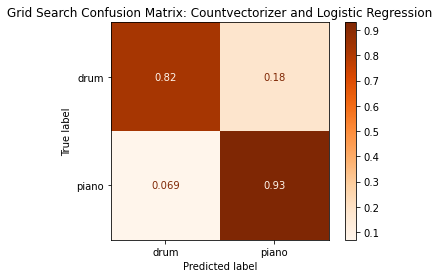

In [466]:
log_cv_gs_conf = ConfusionMatrixDisplay.from_estimator(gs1, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Oranges', normalize = 'true')
log_cv_gs_conf
plt.title('Grid Search Confusion Matrix: Countvectorizer and Logistic Regression');

In [467]:
log_cv_gs_conf.figure_.savefig('./images/log_cv_gs_conf.jpg',dpi = 100)

#### 2.2.4. Grid Search: TfidfVectorizer + LogisticRegression

In [189]:
pipe2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidfvectorizer', 'logisticregression', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvectorizer__min_df', 'tfidfvectorizer__ngram_range', 'tfidfvectorizer__norm', 'tfidfvectorizer__preprocessor', 'tfidfvectorizer__smooth_idf', 'tfidfvectorizer__stop_words', 'tfidfvectorizer__strip_accents', 'tfidfvectorizer__sublinear_tf', 'tfidfvectorizer__token_pattern', 'tfidfvectorizer__tokenizer', 'tfidfvectorizer__use_idf', 'tfidfvectorizer__vocabulary', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_

In [215]:
param_grid2 = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)], 
    'tfidfvectorizer__min_df': [1, 2, 3, 4, 5], 
    'logisticregression__C': [0.1, 0.5, 1.0, 1.5],
             }

In [216]:
gs2 = GridSearchCV(pipe2, param_grid = param_grid2, n_jobs = -1)

In [217]:
gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(min_df=2,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                    

In [218]:
gs2.best_params_

{'logisticregression__C': 1.5,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 1)}

In [495]:
log_tf_gs_train = gs2.best_score_
log_tf_gs_test = cross_val_score(gs2.best_estimator_, X_test, y_test).mean()
log_tf_gs_train, log_tf_gs_test

(0.868361581920904, 0.8558864740998059)

In [220]:
gs2.score(X_train, y_train), gs2.score(X_test, y_test)

(0.9391713747645951, 0.8803516819571865)

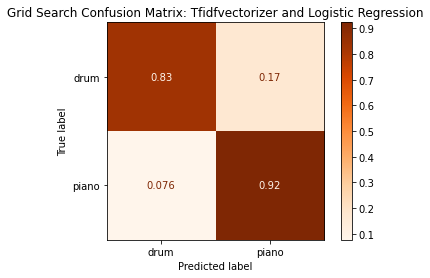

In [468]:
log_tf_gs_conf = ConfusionMatrixDisplay.from_estimator(gs2, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Oranges', normalize = 'true')
log_tf_gs_conf
plt.title('Grid Search Confusion Matrix: Tfidfvectorizer and Logistic Regression');

In [469]:
log_tf_gs_conf.figure_.savefig('./images/log_tf_gs_conf.jpg',dpi = 100)

TfidfVectorizer + LogisticRegression have better result than CountVectorizer + LogisticRegression. 

### 2.3. K Nearest Neighbors

#### 2.3.1. CountVectorizer + KNN

In [417]:
pipe3 = make_pipeline(CountVectorizer(stop_words = stop_words, min_df = 2), KNeighborsClassifier(n_neighbors = 5))

In [418]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [419]:
pipe3.score(X_train, y_train), pipe3.score(X_test, y_test)

(0.8427495291902072, 0.7282110091743119)

In [496]:
knn_cv_train = cross_val_score(pipe3, X_train, y_train).mean()
knn_cv_test = cross_val_score(pipe3, X_test, y_test).mean()
knn_cv_train, knn_cv_test

(0.7096045197740113, 0.7117714886225972)

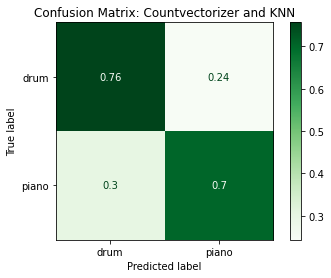

In [470]:
knn_cv_conf = ConfusionMatrixDisplay.from_estimator(pipe3, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Greens', normalize = 'true')
knn_cv_conf
plt.title('Confusion Matrix: Countvectorizer and KNN');

In [471]:
knn_cv_conf.figure_.savefig('./images/knn_cv_conf.jpg',dpi = 100)

#### 2.3.2. TfidfVectorizer + KNN

In [210]:
pipe4 = make_pipeline(TfidfVectorizer(stop_words = stop_words, min_df = 2), KNeighborsClassifier(n_neighbors = 5))

In [211]:
pipe4.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [212]:
pipe4.score(X_train, y_train), pipe4.score(X_test, y_test)

(0.784180790960452, 0.6502293577981652)

In [497]:
knn_tf_train = cross_val_score(pipe4, X_train, y_train).mean()
knn_tf_test = cross_val_score(pipe4, X_test, y_test).mean()
knn_tf_train, knn_tf_test

(0.6404896421845574, 0.6425897274969714)

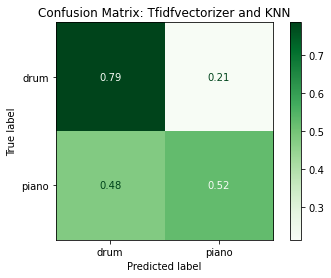

In [472]:
knn_tf_conf = ConfusionMatrixDisplay.from_estimator(pipe4, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Greens', normalize = 'true')
knn_tf_conf
plt.title('Confusion Matrix: Tfidfvectorizer and KNN');

In [473]:
knn_tf_conf.figure_.savefig('./images/knn_tf_conf.jpg',dpi = 100)

#### 2.3.3. Grid Search: CountVectorizer + KNN

In [242]:
pipe3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'countvectorizer', 'kneighborsclassifier', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [243]:
param_grid3 = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)], 
    'countvectorizer__min_df': [2, 3, 4, 5], 
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 11, 15], 
    'kneighborsclassifier__weights': ['uniform', 'distance'], 
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']
             }

In [244]:
gs3 = GridSearchCV(pipe3, param_grid = param_grid3, n_jobs = -1)

In [245]:
gs3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(min_df=2,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                    

In [246]:
gs3.best_params_

{'countvectorizer__min_df': 5,
 'countvectorizer__ngram_range': (1, 2),
 'kneighborsclassifier__metric': 'euclidean',
 'kneighborsclassifier__n_neighbors': 11,
 'kneighborsclassifier__weights': 'distance'}

In [498]:
knn_cv_gs_train = gs3.best_score_
knn_cv_gs_test = cross_val_score(gs3.best_estimator_, X_test, y_test).mean()
knn_cv_gs_train, knn_cv_gs_test

(0.7657250470809792, 0.7603265073781618)

In [248]:
gs3.score(X_train, y_train), gs3.score(X_test, y_test)

(0.9747645951035782, 0.7782874617737003)

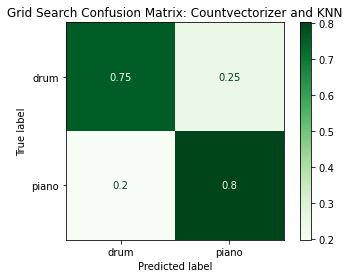

In [474]:
knn_cv_gs_conf = ConfusionMatrixDisplay.from_estimator(gs3, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Greens', normalize = 'true')
knn_cv_gs_conf
plt.title('Grid Search Confusion Matrix: Countvectorizer and KNN');

In [475]:
knn_cv_gs_conf.figure_.savefig('./images/knn_cv_gs_conf.jpg',dpi = 100)

#### 2.3.4. Grid Search: TfidfVectorizer + KNN

In [249]:
pipe4.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidfvectorizer', 'kneighborsclassifier', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvectorizer__min_df', 'tfidfvectorizer__ngram_range', 'tfidfvectorizer__norm', 'tfidfvectorizer__preprocessor', 'tfidfvectorizer__smooth_idf', 'tfidfvectorizer__stop_words', 'tfidfvectorizer__strip_accents', 'tfidfvectorizer__sublinear_tf', 'tfidfvectorizer__token_pattern', 'tfidfvectorizer__tokenizer', 'tfidfvectorizer__use_idf', 'tfidfvectorizer__vocabulary', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [250]:
param_grid4 = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)], 
    'tfidfvectorizer__min_df': [2, 3, 4, 5], 
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 11, 15], 
    'kneighborsclassifier__weights': ['uniform', 'distance'], 
    'kneighborsclassifier__metric': ['euclidean', 'manhattan']
             }

In [251]:
gs4 = GridSearchCV(pipe4, param_grid = param_grid4, n_jobs = -1)

In [252]:
gs4.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(min_df=2,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                    

In [253]:
gs4.best_params_

{'kneighborsclassifier__metric': 'euclidean',
 'kneighborsclassifier__n_neighbors': 7,
 'kneighborsclassifier__weights': 'distance',
 'tfidfvectorizer__min_df': 5,
 'tfidfvectorizer__ngram_range': (1, 3)}

In [499]:
knn_tf_gs_train = gs4.best_score_
knn_tf_gs_test = cross_val_score(gs4.best_estimator_, X_test, y_test).mean()
knn_tf_gs_train, knn_tf_gs_test

(0.7148775894538607, 0.7224738370820136)

In [255]:
gs4.score(X_train, y_train), gs4.score(X_test, y_test)

(0.9745762711864406, 0.7301223241590215)

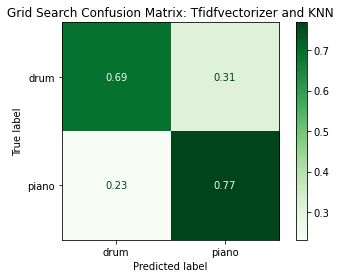

In [476]:
knn_tf_gs_conf = ConfusionMatrixDisplay.from_estimator(gs4, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Greens', normalize = 'true')
knn_tf_gs_conf
plt.title('Grid Search Confusion Matrix: Tfidfvectorizer and KNN');

In [477]:
knn_tf_gs_conf.figure_.savefig('./images/knn_tf_gs_conf.jpg',dpi = 100)

KNN does not perform well as Logistic Regression in the model. 
CountVectorizer + LogisticRegression have better result than TfidfVectorizer + LogisticRegression. 

### 2.4. Random Forest Classifier

#### 2.4.1. CountVectorizer + Random Forest Classifier

In [257]:
pipe5 = make_pipeline(CountVectorizer(stop_words = stop_words, min_df = 2), RandomForestClassifier())

In [258]:
pipe5.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('randomforestclassifier', RandomForestClassifier())])

In [259]:
pipe5.score(X_train, y_train), pipe5.score(X_test, y_test)

(0.991713747645951, 0.8490061162079511)

In [500]:
rfc_cv_train = cross_val_score(pipe5, X_train, y_train).mean()
rfc_cv_test = cross_val_score(pipe5, X_test, y_test).mean()
rfc_cv_train, rfc_cv_test

(0.8369114877589453, 0.8379263789353846)

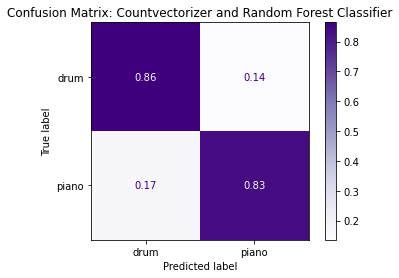

In [478]:
rfc_cv_conf = ConfusionMatrixDisplay.from_estimator(pipe5, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Purples', normalize = 'true')
rfc_cv_conf
plt.title('Confusion Matrix: Countvectorizer and Random Forest Classifier');

In [479]:
rfc_cv_conf.figure_.savefig('./images/rfc_cv_conf.jpg',dpi = 100)

#### 2.4.2. TfidfVectorizer + Random Forest Classifier

In [262]:
pipe6 = make_pipeline(TfidfVectorizer(stop_words = stop_words, min_df = 2), RandomForestClassifier())

In [263]:
pipe6.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('randomforestclassifier', RandomForestClassifier())])

In [264]:
pipe6.score(X_train, y_train), pipe6.score(X_test, y_test)

(0.991713747645951, 0.8562691131498471)

In [501]:
rfc_tf_train = cross_val_score(pipe6, X_train, y_train).mean()
rfc_tf_test = cross_val_score(pipe6, X_test, y_test).mean()
rfc_tf_train, rfc_tf_test

(0.8459510357815443, 0.8451855852174038)

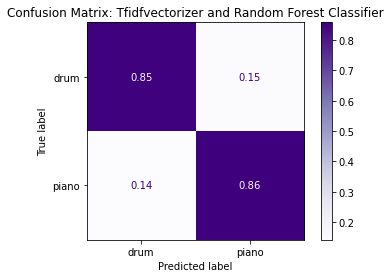

In [480]:
rfc_tf_conf = ConfusionMatrixDisplay.from_estimator(pipe6, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Purples', normalize = 'true')
rfc_tf_conf
plt.title('Confusion Matrix: Tfidfvectorizer and Random Forest Classifier');

In [481]:
rfc_tf_conf.figure_.savefig('./images/rfc_tf_conf.jpg',dpi = 100)

#### 2.4.3. Grid Search: CountVectorizer + Random Forest Classifier

In [267]:
pipe5.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'countvectorizer', 'randomforestclassifier', 'countvectorizer__analyzer', 'countvectorizer__binary', 'countvectorizer__decode_error', 'countvectorizer__dtype', 'countvectorizer__encoding', 'countvectorizer__input', 'countvectorizer__lowercase', 'countvectorizer__max_df', 'countvectorizer__max_features', 'countvectorizer__min_df', 'countvectorizer__ngram_range', 'countvectorizer__preprocessor', 'countvectorizer__stop_words', 'countvectorizer__strip_accents', 'countvectorizer__token_pattern', 'countvectorizer__tokenizer', 'countvectorizer__vocabulary', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 

In [269]:
param_grid5 = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)], 
    'countvectorizer__min_df': [2, 3, 4], 
    'randomforestclassifier__n_estimators': [100, 150, 200], 
    'randomforestclassifier__max_depth': [5, 7, 10, 12, 15], 
    'randomforestclassifier__min_samples_split': [2, 3, 5, 7]
             }

In [270]:
gs5 = GridSearchCV(pipe5, param_grid = param_grid5, n_jobs = -1)

In [271]:
gs5.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(min_df=2,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                    

In [272]:
gs5.best_params_

{'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 1),
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 100}

In [502]:
rfc_cv_gs_train = gs5.best_score_
rfc_cv_gs_test = cross_val_score(gs5.best_estimator_, X_test, y_test).mean()
rfc_cv_gs_train, rfc_cv_gs_test

(0.8028248587570621, 0.803134441638813)

In [274]:
gs5.score(X_train, y_train), gs5.score(X_test, y_test)

(0.8229755178907722, 0.8165137614678899)

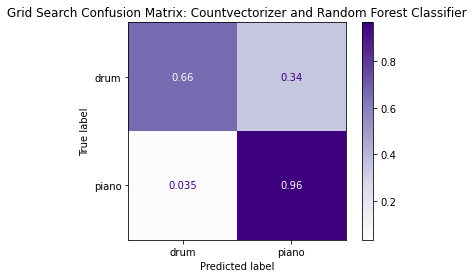

In [482]:
rfc_cv_gs_conf = ConfusionMatrixDisplay.from_estimator(gs5, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Purples', normalize = 'true')
rfc_cv_gs_conf
plt.title('Grid Search Confusion Matrix: Countvectorizer and Random Forest Classifier');

In [483]:
rfc_cv_gs_conf.figure_.savefig('./images/rfc_cv_gs_conf.jpg',dpi = 100)

#### 2.4.4. Grid Search: TfidfVectorizer + Random Forest Classifier

In [280]:
pipe6.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidfvectorizer', 'randomforestclassifier', 'tfidfvectorizer__analyzer', 'tfidfvectorizer__binary', 'tfidfvectorizer__decode_error', 'tfidfvectorizer__dtype', 'tfidfvectorizer__encoding', 'tfidfvectorizer__input', 'tfidfvectorizer__lowercase', 'tfidfvectorizer__max_df', 'tfidfvectorizer__max_features', 'tfidfvectorizer__min_df', 'tfidfvectorizer__ngram_range', 'tfidfvectorizer__norm', 'tfidfvectorizer__preprocessor', 'tfidfvectorizer__smooth_idf', 'tfidfvectorizer__stop_words', 'tfidfvectorizer__strip_accents', 'tfidfvectorizer__sublinear_tf', 'tfidfvectorizer__token_pattern', 'tfidfvectorizer__tokenizer', 'tfidfvectorizer__use_idf', 'tfidfvectorizer__vocabulary', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestcl

In [281]:
param_grid6 = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)], 
    'tfidfvectorizer__min_df': [2, 3, 4], 
    'randomforestclassifier__n_estimators': [100, 150, 200], 
    'randomforestclassifier__max_depth': [5, 7, 10, 12, 15], 
    'randomforestclassifier__min_samples_split': [2, 3, 5, 7]
             }

In [282]:
gs6 = GridSearchCV(pipe6, param_grid = param_grid6, n_jobs = -1)

In [283]:
gs6.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(min_df=2,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                    

In [284]:
gs6.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 150,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 1)}

In [503]:
rfc_tf_gs_train = gs6.best_score_
rfc_tf_gs_test = cross_val_score(gs6.best_estimator_, X_test, y_test).mean()
rfc_tf_gs_train, rfc_tf_gs_test

(0.8026365348399247, 0.8012253149037409)

In [286]:
gs6.score(X_train, y_train), gs6.score(X_test, y_test)

(0.8212806026365348, 0.8149847094801224)

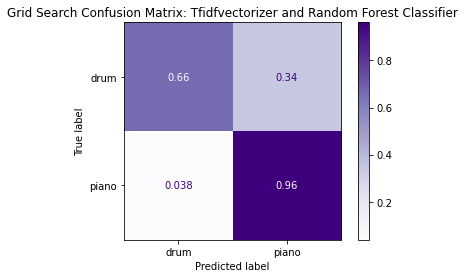

In [484]:
rfc_tf_gs_conf = ConfusionMatrixDisplay.from_estimator(gs6, X_test, y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Purples', normalize = 'true')
rfc_tf_gs_conf
plt.title('Grid Search Confusion Matrix: Tfidfvectorizer and Random Forest Classifier');

In [485]:
rfc_tf_gs_conf.figure_.savefig('./images/rfc_tf_gs_conf.jpg',dpi = 100)

RFC does not beat the accuracy score from Logistic Regression. 
The grid search is not as good as original RFC model. this is something need to be discovered. 

## 3. Advanced Model with Two Features

### 3.1. Logistic Regression

In [337]:
Z = instrument[['title', 'selftext']]
Y = instrument['subreddit']

Z_train, Z_test, Y_train, Y_test = train_test_split(Z, Y, random_state = 42, stratify = Y)

#### 3.1.1. CountVectorizer + Logistic Regression

In [338]:
CV = CountVectorizer(stop_words = stop_words, min_df = 2)

In [339]:
transformer1 = make_column_transformer(
    (CV, 'title'), (CV, 'selftext'), 
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

In [340]:
PIPE1 = make_pipeline(transformer1, LogisticRegression(max_iter = 10000))

In [341]:
PIPE1.fit(Z_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('countvectorizer-1',
                                                  CountVectorizer(min_df=2,
                                                                  stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                      

In [342]:
PIPE1.score(Z_train, Y_train), PIPE1.score(Z_test, Y_test)

(0.9697173620457604, 0.8970736629667003)

In [343]:
cross_val_score(PIPE1, Z_train, Y_train).mean(), cross_val_score(PIPE1, Z_test, Y_test).mean()

(0.8824029473314587, 0.8602333155229882)

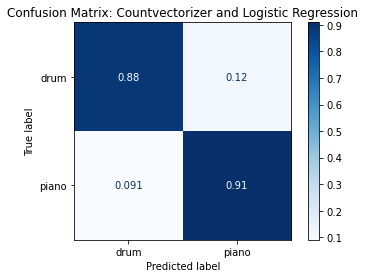

In [505]:
log2_cv_conf = ConfusionMatrixDisplay.from_estimator(PIPE1, Z_test, Y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Blues', normalize = 'true');
log2_cv_conf
plt.title('Confusion Matrix: Countvectorizer and Logistic Regression');

In [506]:
log2_cv_conf.figure_.savefig('./images/log2_cv_conf.jpg',dpi = 100)

#### 3.1.2. TfidfVectorizer + Logistic Regression

In [327]:
TF = TfidfVectorizer(stop_words = stop_words, min_df = 2)

In [328]:
transformer2 = make_column_transformer(
    (TF, 'title'), (TF, 'selftext'), 
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

In [329]:
PIPE2 = make_pipeline(transformer2, LogisticRegression(max_iter = 10000))

In [330]:
PIPE2.fit(Z_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidfvectorizer-1',
                                                  TfidfVectorizer(min_df=2,
                                                                  stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                      

In [331]:
PIPE2.score(Z_train, Y_train), PIPE2.score(Z_test, Y_test)

(0.9500336473755047, 0.8975782038345106)

In [332]:
cross_val_score(PIPE2, Z_train, Y_train).mean(), cross_val_score(PIPE2, Z_test, Y_test).mean()

(0.8876195371149114, 0.8556993104852048)

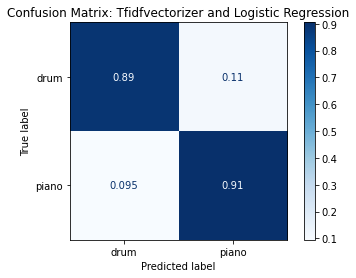

In [507]:
log2_tf_conf = ConfusionMatrixDisplay.from_estimator(PIPE2, Z_test, Y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Blues', normalize = 'true')
log2_tf_conf
plt.title('Confusion Matrix: Tfidfvectorizer and Logistic Regression');

In [508]:
log2_tf_conf.figure_.savefig('./images/log2_tf_conf.jpg',dpi = 100)

#### 3.1.3. Grid Search: CountVectorizer + Logistic Regression

In [359]:
PIPE1.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'logisticregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__countvectorizer-1', 'columntransformer__countvectorizer-2', 'columntransformer__countvectorizer-1__analyzer', 'columntransformer__countvectorizer-1__binary', 'columntransformer__countvectorizer-1__decode_error', 'columntransformer__countvectorizer-1__dtype', 'columntransformer__countvectorizer-1__encoding', 'columntransformer__countvectorizer-1__input', 'columntransformer__countvectorizer-1__lowercase', 'columntransformer__countvectorizer-1__max_df', 'columntransformer__countvectorizer-1__max_features', 'columntransformer__countvectorizer-1__min_df', 'columntransformer__countvectorizer-1__ngram_range', 'columntransformer__countvector

In [360]:
PARAM_grid1 = {
    'columntransformer__countvectorizer-1__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)], 
    'columntransformer__countvectorizer-1__min_df': [2, 3, 4], 
    'columntransformer__countvectorizer-2__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)], 
    'columntransformer__countvectorizer-2__min_df': [2, 3, 4], 
    'logisticregression__C': [0.5, 1.0, 1.5]
             }

In [361]:
GS1 = GridSearchCV(PIPE1, param_grid = PARAM_grid1, n_jobs = -1)

In [362]:
GS1.fit(Z_train, Y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('countvectorizer-1',
                                                                         CountVectorizer(min_df=2,
                                                                                         stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                 

In [363]:
GS1.best_params_

{'columntransformer__countvectorizer-1__min_df': 2,
 'columntransformer__countvectorizer-1__ngram_range': (1, 3),
 'columntransformer__countvectorizer-2__min_df': 2,
 'columntransformer__countvectorizer-2__ngram_range': (1, 3),
 'logisticregression__C': 1.5}

In [364]:
GS1.best_score_, cross_val_score(GS1.best_estimator_, Z_test, Y_test).mean()

(0.8830760648254341, 0.865276187568379)

In [365]:
GS1.score(Z_train, Y_train), GS1.score(Z_test, Y_test)

(0.980820995962315, 0.8990918264379415)

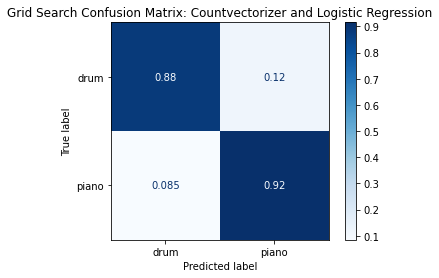

In [510]:
log2_cv_gs_conf = ConfusionMatrixDisplay.from_estimator(GS1, Z_test, Y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Blues', normalize = 'true')
log2_cv_gs_conf
plt.title('Grid Search Confusion Matrix: Countvectorizer and Logistic Regression');

In [511]:
log2_cv_gs_conf.figure_.savefig('./images/log2_cv_gs_conf.jpg',dpi = 100)

#### 3.1.4. Grid Search: TfidfVectorizer + Logistic Regression

In [367]:
PIPE2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'logisticregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__tfidfvectorizer-1', 'columntransformer__tfidfvectorizer-2', 'columntransformer__tfidfvectorizer-1__analyzer', 'columntransformer__tfidfvectorizer-1__binary', 'columntransformer__tfidfvectorizer-1__decode_error', 'columntransformer__tfidfvectorizer-1__dtype', 'columntransformer__tfidfvectorizer-1__encoding', 'columntransformer__tfidfvectorizer-1__input', 'columntransformer__tfidfvectorizer-1__lowercase', 'columntransformer__tfidfvectorizer-1__max_df', 'columntransformer__tfidfvectorizer-1__max_features', 'columntransformer__tfidfvectorizer-1__min_df', 'columntransformer__tfidfvectorizer-1__ngram_range', 'columntransformer__tfidfvector

In [368]:
PARAM_grid2 = {
    'columntransformer__tfidfvectorizer-1__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)], 
    'columntransformer__tfidfvectorizer-1__min_df': [2, 3, 4], 
    'columntransformer__tfidfvectorizer-2__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2)], 
    'columntransformer__tfidfvectorizer-2__min_df': [2, 3, 4], 
    'logisticregression__C': [0.5, 1.0, 1.5]
             }

In [369]:
GS2 = GridSearchCV(PIPE2, param_grid = PARAM_grid2, n_jobs = -1)

In [370]:
GS2.fit(Z_train, Y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidfvectorizer-1',
                                                                         TfidfVectorizer(min_df=2,
                                                                                         stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                 

In [371]:
GS2.best_params_

{'columntransformer__tfidfvectorizer-1__min_df': 2,
 'columntransformer__tfidfvectorizer-1__ngram_range': (1, 1),
 'columntransformer__tfidfvectorizer-2__min_df': 3,
 'columntransformer__tfidfvectorizer-2__ngram_range': (1, 2),
 'logisticregression__C': 1.5}

In [372]:
GS2.best_score_, cross_val_score(GS2.best_estimator_, Z_test, Y_test).mean()

(0.8903121486805254, 0.8627623845507977)

In [373]:
GS2.score(Z_train, Y_train), GS2.score(Z_test, Y_test)

(0.957099596231494, 0.8980827447023209)

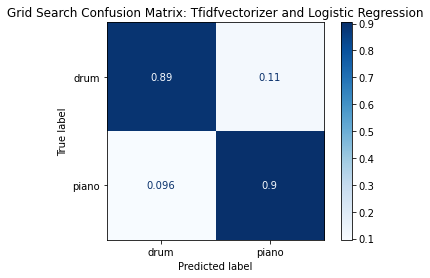

In [512]:
log2_tf_gs_conf = ConfusionMatrixDisplay.from_estimator(GS2, Z_test, Y_test, 
                                      display_labels = ['drum', 'piano'], cmap = 'Blues', normalize = 'true')
log2_tf_gs_conf
plt.title('Grid Search Confusion Matrix: Tfidfvectorizer and Logistic Regression');

In [513]:
log2_tf_gs_conf.figure_.savefig('./images/log2_tf_gs_conf.jpg',dpi = 100)

The two feature model is the best estimator for the seleted model. the FP was reduced to 0.11/0.12 from 0.17/0.18. Due to computing limitation, only Logistic Regression is tried. 

* I don't know how to make the figure of The model performace that includes all cross validation score from all 16 models. Becuase the x-axis contains three stepped distribution. For example, One Feature Model - Logistic Regression - CountVectorizer. So I made the figure in Excel. the excel file is located in the image folder. 

## 4. Conclusions

* The proposed model increased accuracy rate from 12.5% o 34.8% from baseline. 

* However, it encountered bottleneck for accuracy score around 90%. 

* In order to improve, three methods can be tried in future:

     1). collect more data points

     2). optimize model by further digging on parameters

     3). try other models

* The model is ready to apply to other subreddit with some minor parameter adjustment. 